### Sahil Saleem - CloveStack

# I have followed these steps for this analysis
- Data Processing
- Redundancy and data cleaning
- Data Analysis
- Uploading to MongoDB
- Results

# Data Processing Stage

In [1]:
# Import all required dependencies
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from pymongo import MongoClient

loan = pd.read_csv("loan.csv", sep=",")

C:\Users\Asus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
# First Lets check all the different columns
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [3]:
# Also lets see a brief example
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


#### From an initial glance "loan_status" column seems to be the attribute to which we need to make comparisons to.
It can take 3 Values :
- Fully Paid (No default on loan and fully settled)
- Charged Off (There is a default on loans)
- Current (No default till now)

# Redundancy and Data Cleaning Stage

In [4]:
# First lets check if there are any empty/unused columns
loan.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [5]:
# Lets then find it percentage wise so we can drop the columns with larger %
(loan.isnull().sum()/len(loan.index))*100

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64

In [6]:
# As I see columns with more than 90 % initially unused I drop those
loan = loan.drop(loan.columns[(loan.isnull().sum()/len(loan.index)) * 100 > 90], axis=1)
print(loan.shape)

(39717, 55)


In [7]:
# Now find the highest % again
(loan.isnull().sum()/len(loan.index))*100

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      6.191303
emp_length                     2.706650
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.580507
purpose                        0.000000
title                          0.027696
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


#### The highest is "mths_since_last_delinq" with almost 65% unused
#### mths_since_last_delinq indicates number of months since a financial obligation was not met, but this data is only available after the loan is issued so it can be dropped

In [8]:
loan = loan.drop('mths_since_last_delinq', axis=1)

In [9]:
# Now find the highest % again
(loan.isnull().sum()/len(loan.index))*100

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      6.191303
emp_length                     2.706650
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.580507
purpose                        0.000000
title                          0.027696
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [10]:
# Next highest is desc 
loan.loc[:, ['desc']].head()

,desc
0,Borrower added on 12/22/11 > I need to upgra...
1,Borrower added on 12/22/11 > I plan to use t...
2,NaN
3,Borrower added on 12/21/11 > to pay for prop...
4,Borrower added on 12/21/11 > I plan on combi...


In [11]:
# As the desc is the reason why a customer needs a loan and this column isnt directly usable maybe by some text analysis I am dropping this also
loan = loan.drop('desc', axis=1)

In [12]:
# Now find the highest % again
(loan.isnull().sum()/len(loan.index))*100

id                            0.000000
member_id                     0.000000
loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_title                     6.191303
emp_length                    2.706650
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
pymnt_plan                    0.000000
url                           0.000000
purpose                       0.000000
title                         0.027696
zip_code                      0.000000
addr_state                    0.000000
dti                           0.000000
delinq_2yrs                   0.000000
earliest_cr_line         

#### As most unused is less than 10% which is enough as we arent modelling the data I am done with checking column-wise

In [13]:
# Lets check empty/redundant data row-wise now
loan.isnull().sum(axis=1)

0        1
1        0
2        1
3        0
4        0
        ..
39712    4
39713    4
39714    5
39715    5
39716    4
Length: 39717, dtype: int64

In [14]:
# As the largest I see is 5 Let me make sure thats the case 
len(loan[loan.isnull().sum(axis=1) > 5].index)

0

#### So the data seems clean column and row-wise by now

In [15]:
# Next we can check if the column data types are correct
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [16]:
# Straight away I notice the int_rate which is numeric is stored as an object so Lets convert that using lambdas
loan['int_rate'] = loan['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))

In [17]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  float64
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [18]:
loan.loc[:, ['emp_length']].head()

,emp_length
0,10+ years
1,< 1 year
2,10+ years
3,10+ years
4,1 year


In [19]:
# Further the emp_length is an object when it actually gives a numeric value so lets remodel that column
loan = loan[~loan['emp_length'].isnull()]
loan['emp_length'] = loan['emp_length'].apply(lambda x: re.findall('\d+', str(x))[0])
loan['emp_length'] = loan['emp_length'].apply(lambda x: pd.to_numeric(x))

In [20]:
loan.loc[:, ['emp_length']].head()

,emp_length
0,10
1,1
2,10
3,10
4,1


In [21]:
# We should also remove the columns that dont make sense for our analysis
# That is the columns that have values after a loan is issued
# From the attribute name itself these were what I found
atrributes_that_make_no_sense_for_analysis =  [
  "title", 
  "url", 
  "zip_code", 
  "addr_state",
  "total_acc",
  "out_prncp",
  "out_prncp_inv",
  "total_pymnt",
  "total_pymnt_inv",
  "total_rec_prncp",
  "total_rec_int",
  "total_rec_late_fee",
  "recoveries",
  "delinq_2yrs",
  "earliest_cr_line",
  "inq_last_6mths",
  "open_acc",
  "pub_rec",
  "revol_bal",
  "revol_util",
  "collection_recovery_fee",
  "last_pymnt_d",
  "last_pymnt_amnt",
  "last_credit_pull_d",
  "application_type"]
df = loan.drop(atrributes_that_make_no_sense_for_analysis, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38642 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38642 non-null  int64  
 1   member_id                   38642 non-null  int64  
 2   loan_amnt                   38642 non-null  int64  
 3   funded_amnt                 38642 non-null  int64  
 4   funded_amnt_inv             38642 non-null  float64
 5   term                        38642 non-null  object 
 6   int_rate                    38642 non-null  float64
 7   installment                 38642 non-null  float64
 8   grade                       38642 non-null  object 
 9   sub_grade                   38642 non-null  object 
 10  emp_title                   37202 non-null  object 
 11  emp_length                  38642 non-null  int64  
 12  home_ownership              38642 non-null  object 
 13  annual_inc                  386

#### We are left with 28 columns which can moreover help with the analysis stage

# Data Analysis Stage

In [22]:
# Fully Paid Loans are most in number 
df['loan_status'].value_counts()

Fully Paid     32145
Charged Off     5399
Current         1098
Name: loan_status, dtype: int64

In [23]:
# Data in the current status can be removed as these dont give any specific indication on the defaulting status
df = df[df['loan_status'] != 'Current']

# We need to change the loan_status attribute to binary as our classification is based on if the customer is defaulting(1) or not(0)
# Also convert object loan_status to a numeric
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x=='Fully Paid' else 1)
df['loan_status'] = df['loan_status'].apply(lambda x: pd.to_numeric(x))
df['loan_status'].value_counts()


0    32145
1     5399
Name: loan_status, dtype: int64

In [24]:
# Calculate the average rate of default 
round(np.mean(df['loan_status']), 2) * 100

14.000000000000002

#### In the given dataset, on average 14% of all loans default

## Univariate Analysis

In [25]:
# This is the dataframe after cleaning and these are the attributes 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37544 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          37544 non-null  int64  
 1   member_id                   37544 non-null  int64  
 2   loan_amnt                   37544 non-null  int64  
 3   funded_amnt                 37544 non-null  int64  
 4   funded_amnt_inv             37544 non-null  float64
 5   term                        37544 non-null  object 
 6   int_rate                    37544 non-null  float64
 7   installment                 37544 non-null  float64
 8   grade                       37544 non-null  object 
 9   sub_grade                   37544 non-null  object 
 10  emp_title                   36136 non-null  object 
 11  emp_length                  37544 non-null  int64  
 12  home_ownership              37544 non-null  object 
 13  annual_inc                  375

<AxesSubplot:>

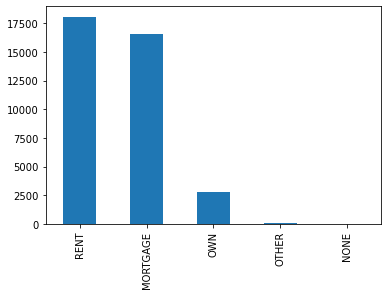

In [26]:
# Number of people who lived in rent,mortgages who applied for loans were the highest
df['home_ownership'].value_counts().plot.bar()

<AxesSubplot:>

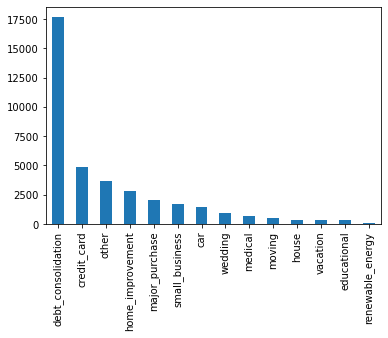

In [27]:
df['purpose'].value_counts().plot.bar()

<AxesSubplot:>

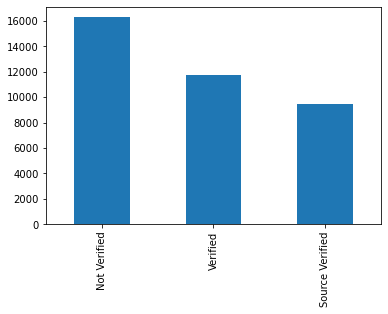

In [28]:
# Most people who applied for loans were not verified
df['verification_status'].value_counts().plot.bar()

<AxesSubplot:>

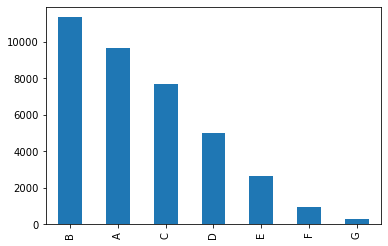

In [29]:
# Most people were from grade B who applied for loans
df['grade'].value_counts().plot.bar()

#### This analysis isnt giving me much insight into how these translates into the people who default so lets try bivariate analysis

# Bivariate Analysis

### Non Contigous Analysis

In [30]:
# Function that we can use for comparing different attributes against loan_status ( chance of defaulting) 
def compare_plot(var):
    sns.barplot(x=var, y='loan_status', data=df)
    plt.show()

#### Lets use this function to do an analysis on different attributes like home_ownership, grade, term, etc to draw some trends

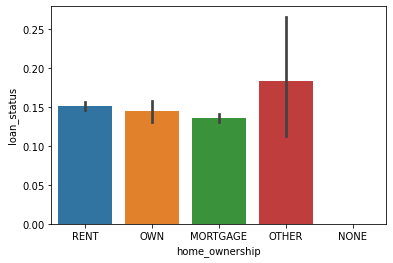

In [31]:
compare_plot('home_ownership')

#### Here we can see that for mortgaged houses the chances of defaulting is least

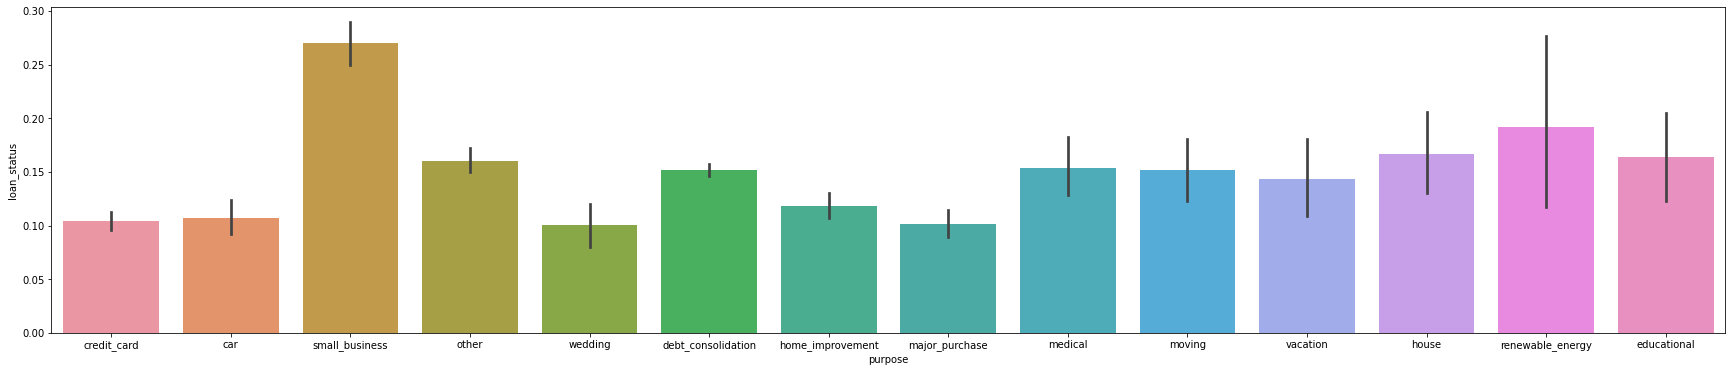

In [32]:
plt.figure(figsize=(30, 6))
compare_plot('purpose')

#### Here we can see that small business have a higher chance of defaulting

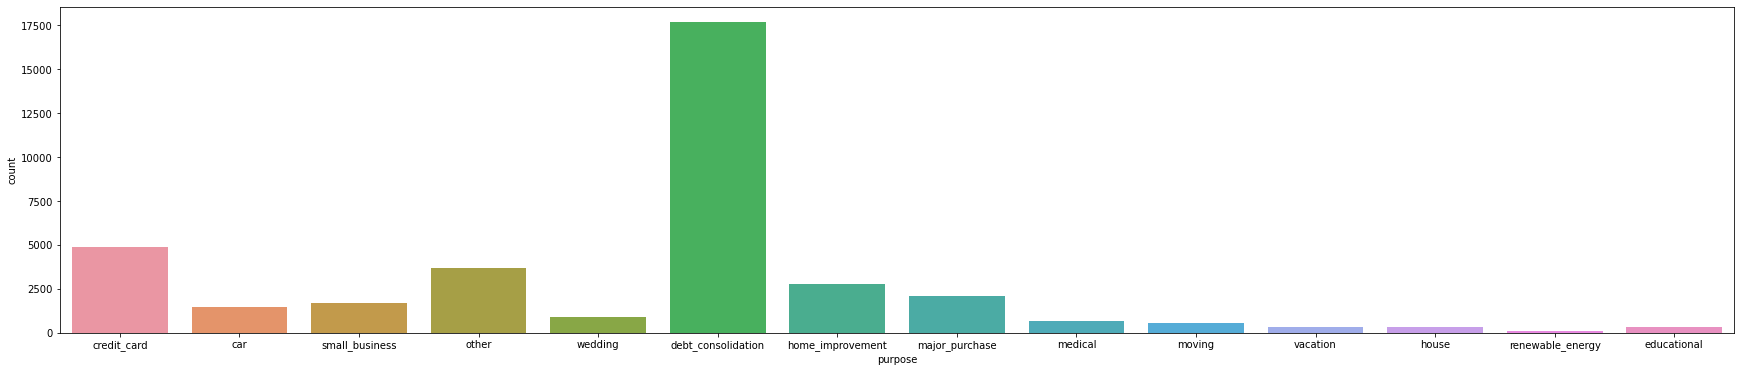

In [33]:
plt.figure(figsize=(30, 6))
sns.countplot(x='purpose', data=df)
plt.show()
# This needs a bivariate analysis as there are multiple attributes

#### We can clearly see that for debt consolidation the number of loans issued are highest

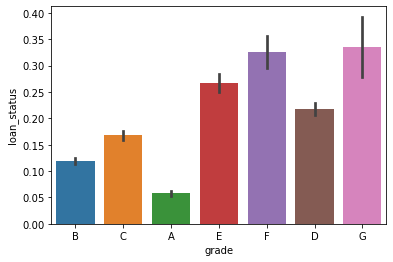

In [34]:
compare_plot('grade')

#### As expected from grade A -> G the chance of defaulting increases

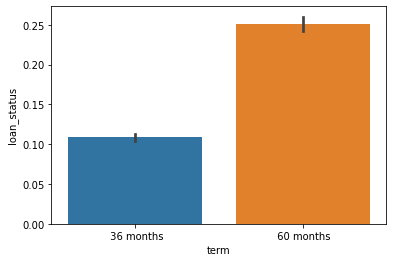

In [35]:
compare_plot('term')

#### Clearly when the loan is given for a longer term  the higher the chance of defaulting

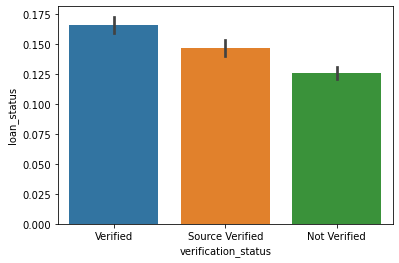

In [36]:
compare_plot('verification_status')

#### If a loan is verified interestingly chance of defaulting is higher while when it is not verified it is much lesser

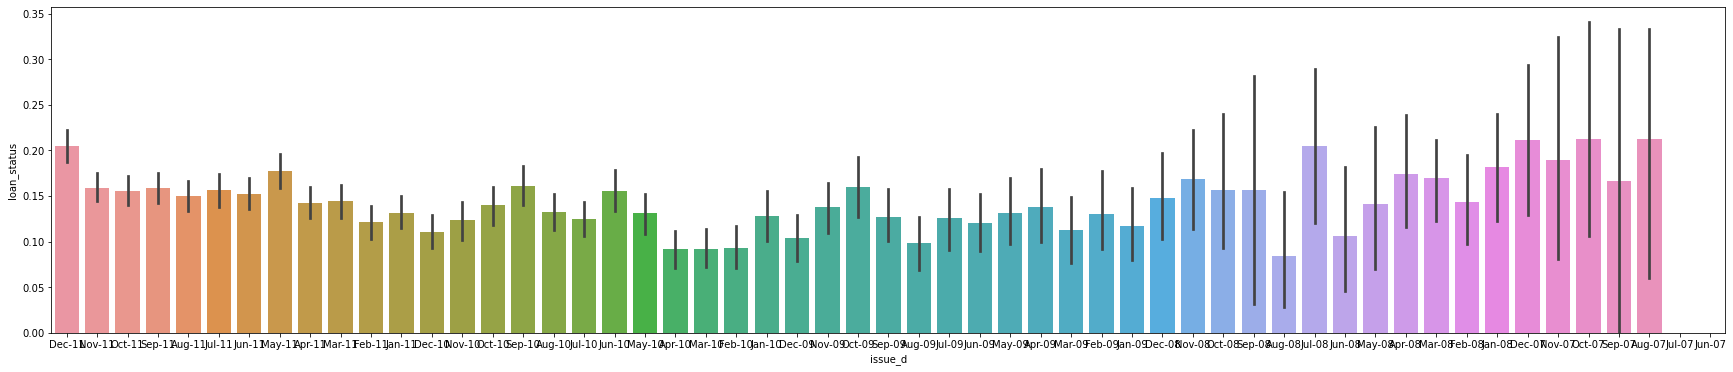

In [37]:
# Another interesting way to look at this data is too see in which years and months loans were issued the most
plt.figure(figsize=(30, 6))
compare_plot('issue_d')

In [38]:
# This is hardly readable as the issue_d is an object, so lets do that data remodelling
df['issue_d'] = df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y'))

In [39]:
df['month'] = df['issue_d'].apply(lambda x: x.month)
df['year'] = df['issue_d'].apply(lambda x: x.year)

# Analysis wrt to year
df.groupby('year').year.count()

year
2007      251
2008     1562
2009     4716
2010    11214
2011    19801
Name: year, dtype: int64

#### As the years went on the number of loans issued have also increased

In [40]:
# Analysis wrt to months
df.groupby('month').month.count()

month
1     2331
2     2278
3     2632
4     2756
5     2838
6     3094
7     3253
8     3321
9     3394
10    3637
11    3890
12    4120
Name: month, dtype: int64

#### As months passed there has been a steady inc in the number of loans issued and in December it was highest

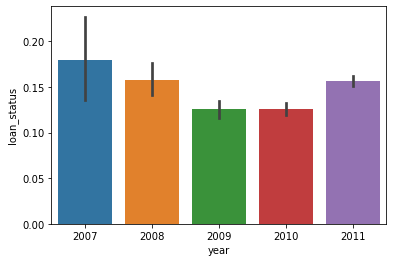

In [41]:
# Now we can plot against year/month 
compare_plot('year')

#### In 2007 we have the highest defaulters, this could be due to the recession at the time

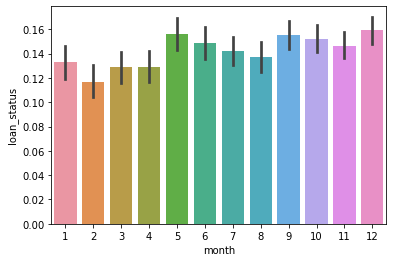

In [42]:
compare_plot('month')

#### In the month of May and Dec the defaulting rate was high

### Contigous Analysis

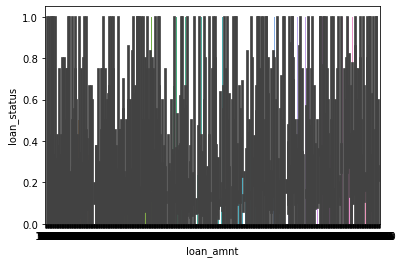

In [43]:
# The earlier comparison technique wont work for such data as it needs to be distribued
compare_plot('loan_amnt')

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


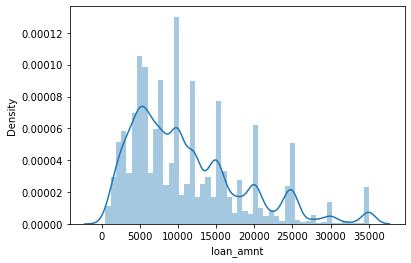

In [44]:
# So lets use a distplot to visualize the density of the data first
sns.distplot(df['loan_amnt'])
plt.show()

In [45]:
# Categorizing this contigous data will make the comparison much easier
def categorize_loan_amnt(amnt):
    if amnt < 5000:
        return 'low'
    elif amnt >=5000 and amnt < 15000:
        return 'medium'
    elif amnt  >= 15000 and amnt < 25000:
        return 'high'
    else:
        return 'very high'
        
df['loan_amnt'] = df['loan_amnt'].apply(lambda x: categorize_loan_amnt(x))

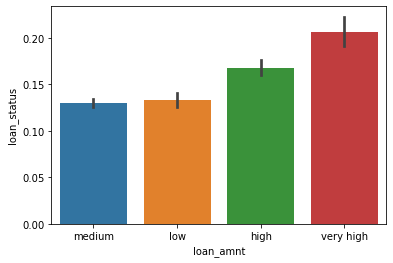

In [46]:
# Now if we plot against this categorized df
compare_plot('loan_amnt')

#### I found that if the loan amount goes high then the chances of defaulting on that loan also goes up

In [47]:
# I did this distribution for all other contigous attributes that I found
df['funded_amnt_inv'] = df['funded_amnt_inv'].apply(lambda x: categorize_loan_amnt(x))
def int_rate(n):
    if n <= 10:
        return 'low'
    elif n > 10 and n <=15:
        return 'medium'
    else:
        return 'high'
    
    
df['int_rate'] = df['int_rate'].apply(lambda x: int_rate(x))
def dti(n):
    if n <= 10:
        return 'low'
    elif n > 10 and n <=20:
        return 'medium'
    else:
        return 'high'
    

df['dti'] = df['dti'].apply(lambda x: dti(x))
def funded_amount(n):
    if n <= 5000:
        return 'low'
    elif n > 5000 and n <=15000:
        return 'medium'
    else:
        return 'high'
    
df['funded_amnt'] = df['funded_amnt'].apply(lambda x: funded_amount(x))
def installment(n):
    if n <= 200:
        return 'low'
    elif n > 200 and n <=400:
        return 'medium'
    elif n > 400 and n <=600:
        return 'high'
    else:
        return 'very high'
    
df['installment'] = df['installment'].apply(lambda x: installment(x))
def annual_income(n):
    if n <= 50000:
        return 'low'
    elif n > 50000 and n <=100000:
        return 'medium'
    elif n > 100000 and n <=150000:
        return 'high'
    else:
        return 'very high'

df['annual_inc'] = df['annual_inc'].apply(lambda x: annual_income(x))
df = df[~df['emp_length'].isnull()]

def emp_length(n):
    if n <= 1:
        return 'beginner'
    elif n > 1 and n <=3:
        return 'intermediate'
    elif n > 3 and n <=7:
        return 'professional'
    else:
        return 'expert'

df['emp_length'] = df['emp_length'].apply(lambda x: emp_length(x))

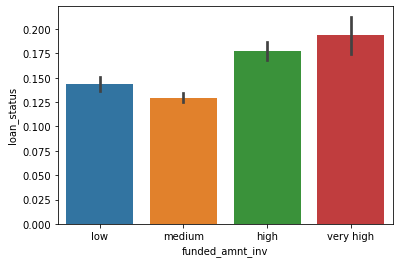

In [48]:
# Then plotted all of them against loan_status
compare_plot('funded_amnt_inv')

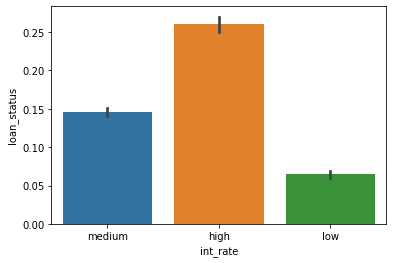

In [49]:
compare_plot('int_rate')

#### Higher the interest rates higher is the chance of defaulting

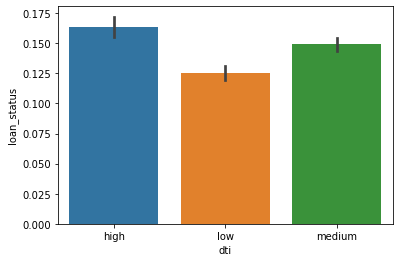

In [50]:
compare_plot('dti')

#### DTI indicates debt to income ratio , generally lower the dti the better

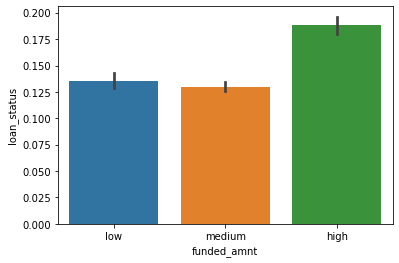

In [51]:
compare_plot('funded_amnt')

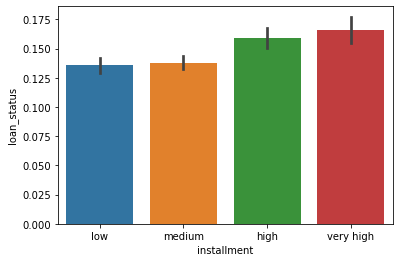

In [52]:
compare_plot('installment')

#### Higher the installment amount to be paid , more chance to default

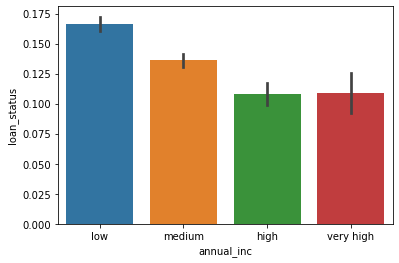

In [53]:
compare_plot('annual_inc')

#### As we move from lower to higher income chances of defaulting go down

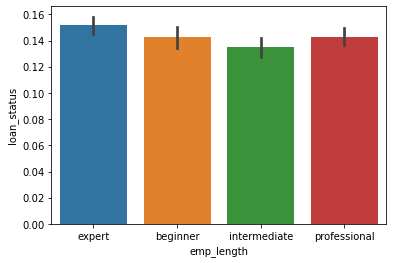

In [54]:
compare_plot('emp_length')

#### I have made this classification based on the number of years worked and this isnt giving me much to analyse

#### I am picking up the "purpose" attribute again as it is a good metric to decide on how loans default

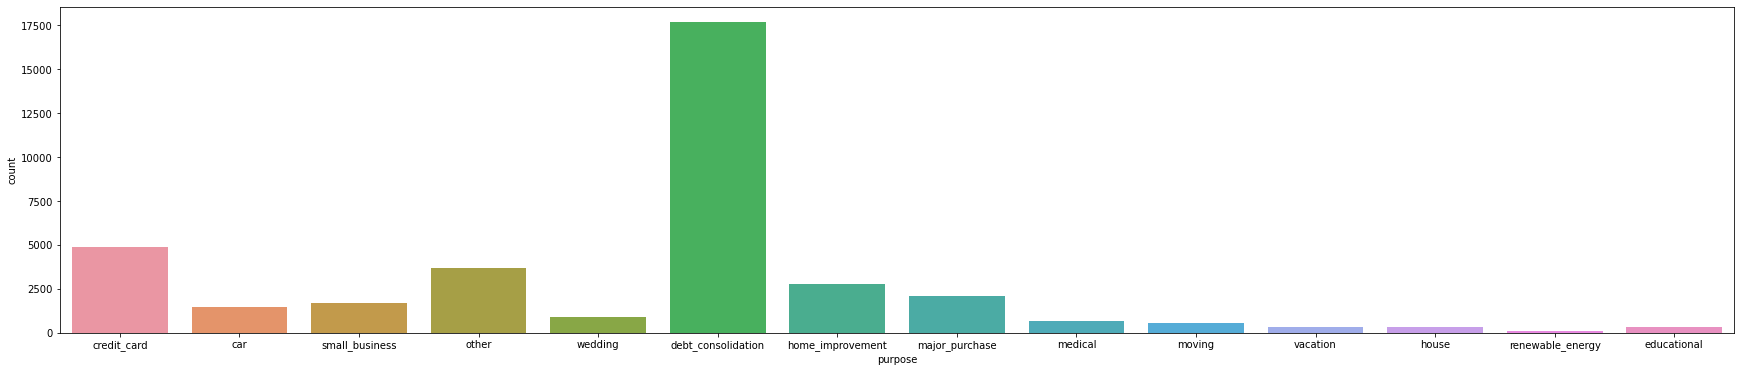

In [55]:
plt.figure(figsize=(30, 6))
sns.countplot(x='purpose', data=df)
plt.show()

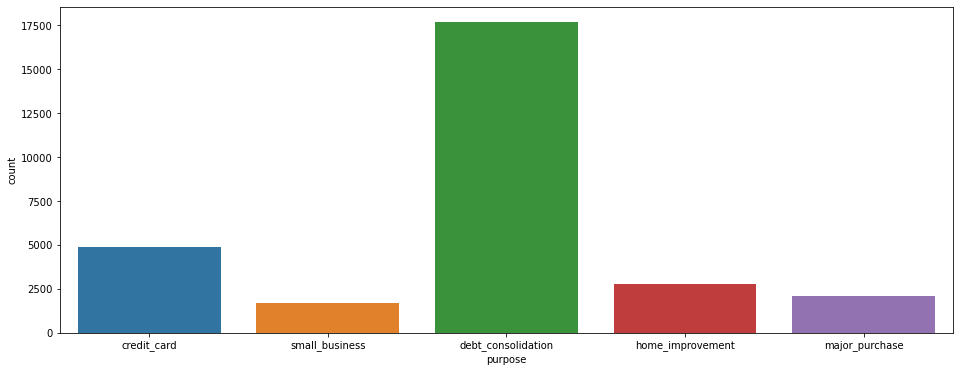

In [56]:
# The top 5 distinct are debt, credit card, home_improvement, major purchase, small bussiness so let us filter these
main_purposes = ["debt_consolidation","credit_card","home_improvement","major_purchase","small_business"]
df = df[df['purpose'].isin(main_purposes)]
plt.figure(figsize=(16, 6))
sns.countplot(x=df['purpose'])
plt.show()

In [57]:
# I have created a bivariate anaylsis function here against loan_status and purpose
def bivariate_plot(var):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=var, y='loan_status', hue='purpose', data=df)
    plt.show()

#### I have then plotted this against all other attributes that make sense comparing to

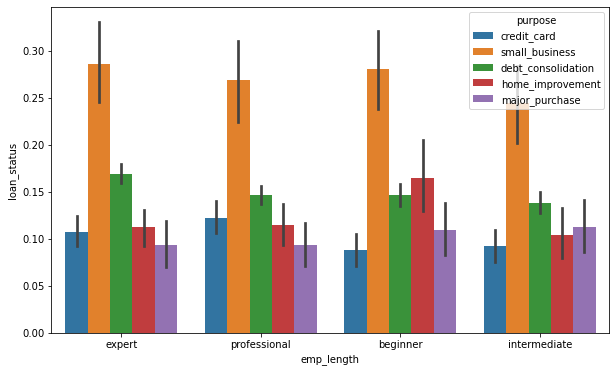

In [58]:
bivariate_plot('emp_length')

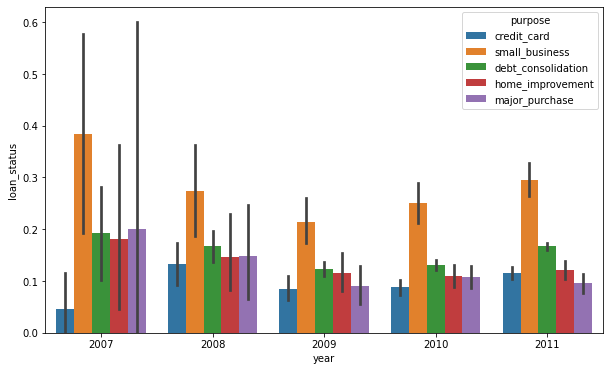

In [59]:
bivariate_plot('year')

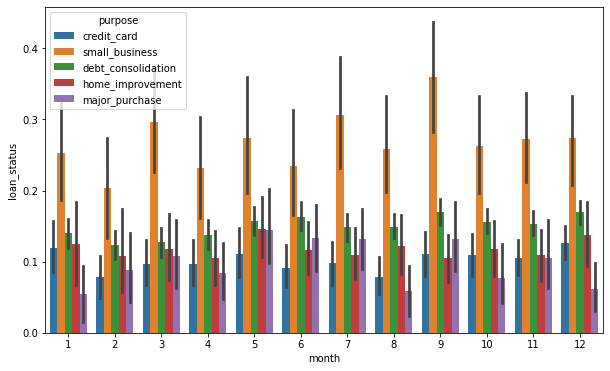

In [60]:
bivariate_plot('month')

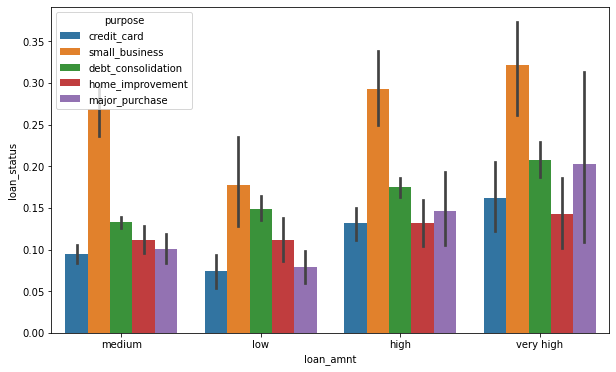

In [61]:
bivariate_plot('loan_amnt')

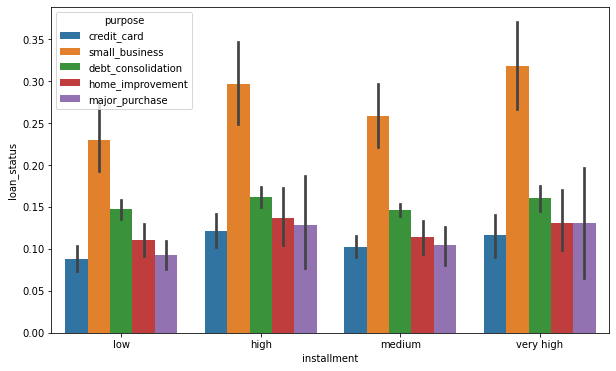

In [62]:
bivariate_plot('installment')

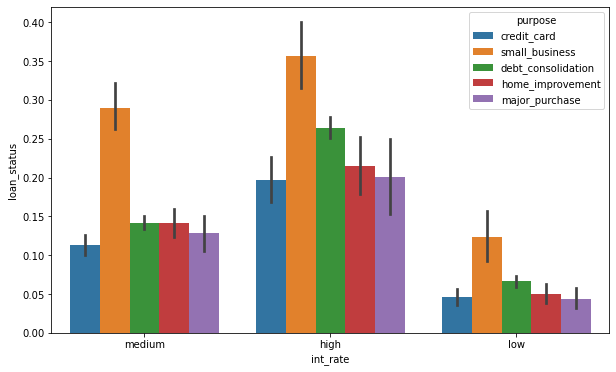

In [63]:
bivariate_plot('int_rate')

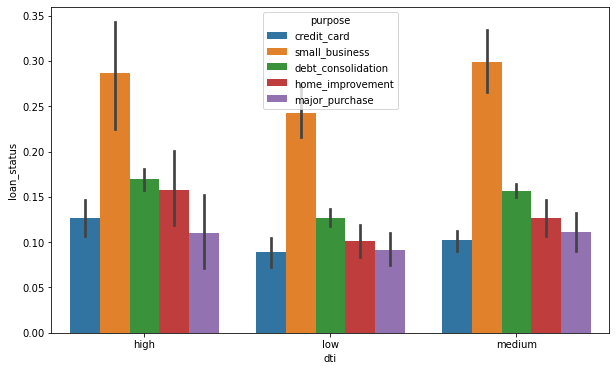

In [64]:
bivariate_plot('dti')

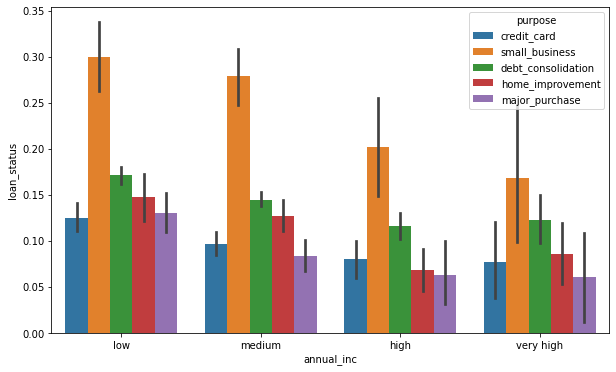

In [65]:
bivariate_plot('annual_inc')

# Uploading to MongoDB

In [66]:
try:
  # Connect to MongoDB
  client =  MongoClient("mongodb+srv://<username>:<password>@cluster0.hhq3cxi.mongodb.net/?retryWrites=true&w=majority")
  db = client['LoanDB']
  collection = db['LendingPSCollection']

  df.reset_index(inplace=True)
  data_dict = df.to_dict("records")

  # Insert collection
  collection.insert_many(data_dict)
  print("Uploaded Sucessfully !")
except Exception as e:
  print("Connection Failed: ", e)

Uploaded Sucessfully !


#### Example
<img src="https://imgur.com/YRriTDJ.png" width="500" height="300"/>

# Results

In [67]:
# Even though this analysis gives me a better idea of what attributes can cause what chance of a default it is still hard to see on average how these attributes vary 
# Inorder to do so I thought of grouping them and then find the variations of loan_status against that attribute

# Example
df.groupby('int_rate').loan_status.mean().sort_values(ascending=False)

int_rate
high      0.256809
medium    0.144163
low       0.061042
Name: loan_status, dtype: float64

In [68]:
# To find the percentage change just need to subtract highest from lowest 
def diff_rate(var):
    rates = df.groupby(var).loan_status.mean().sort_values(ascending=False)
    return (round(rates, 2), round(rates[0] - rates[-1], 2) * 100)

rates, diff = diff_rate('int_rate')
print(diff)

20.0


#### As we move from low to high interest rates there there is 20 % increase of chance of defaulting

In [69]:
# I applied this logic to all object type attributes in the data frame as they will show the variation
df_new = df.loc[:, df.dtypes == object]
df_new['loan_status'] = df['loan_status']

<ipython-input-69-021ee44ac5bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['loan_status'] = df['loan_status']


In [70]:
finalJSON = {i: diff_rate(i)[1] for i in df_new.columns if i != 'loan_status'}
print(json.dumps(finalJSON, indent=2))

{
  "loan_amnt": 8.0,
  "funded_amnt": 6.0,
  "funded_amnt_inv": 6.0,
  "term": 15.0,
  "int_rate": 20.0,
  "installment": 3.0,
  "grade": 28.000000000000004,
  "sub_grade": 48.0,
  "emp_title": 100.0,
  "emp_length": 2.0,
  "home_ownership": 19.0,
  "annual_inc": 6.0,
  "verification_status": 4.0,
  "pymnt_plan": 0.0,
  "purpose": 17.0,
  "dti": 4.0,
  "initial_list_status": 0.0
}
